## Реализация функций

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from icp import icp


def do_laser_scan(robot_position: (float, float),
                  room_size: int,
                  room: np.ndarray,
                  start_angle: int,
                  angle_step: int,
                  laser_scan_max_distance: int) -> list[(int, float)]:
    scan = []

    for angle in np.arange(0, 360, angle_step):
        theta = np.radians(start_angle + angle)
        distance = 0

        for r in range(1, laser_scan_max_distance):
            x = int(robot_position[0] + r * np.cos(theta))
            y = int(robot_position[1] + r * np.sin(theta))

            if x < 0 or y < 0 or x >= room_size or y >= room_size or room[y, x] == 1:
                break

            distance += 1

        scan.append((angle, distance))
    return scan


def draw_room_with_scan(title_name: str,
                        robot_position: (float, float),
                        room: np.ndarray,
                        column_positions: list[list[int]],
                        scan: list[(int, float)],
                        start_angle: int):
    plt.figure(figsize=(10, 10))
    plt.imshow(room, cmap="Greys", origin="lower")
    plt.scatter(*zip(*column_positions), marker="s", color="blue", label="Columns")
    plt.scatter(robot_position[0], robot_position[1], color="red", label="Scanner")

    for angle, distance in scan:
        if distance != -1:
            rad = np.radians(start_angle + angle)
            end_point = (robot_position[0] + distance * np.cos(rad), robot_position[1] + distance * np.sin(rad))

            if angle == 0:
                plt.plot([robot_position[0], end_point[0]], [robot_position[1], end_point[1]], color="red", linewidth=1)
            else:
                plt.plot([robot_position[0], end_point[0]], [robot_position[1], end_point[1]], color="green", linewidth=0.5)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{title_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def convert_polar_to_coord(point: (float, float)) -> (float, float):
    angle, r = point
    theta = np.radians(angle)
    return r * np.cos(theta), r * np.sin(theta)


def transform_polar_scan_to_points_array(scan: list[(int, float)]) -> np.ndarray:
    return np.array([convert_polar_to_coord(point) for point in scan])


def transform_point(point: (float, float),
                    transform_matrix: np.ndarray) -> (float, float):
    x, y = point
    transformed_point = np.dot(transform_matrix, np.array([x, y, 1]))
    return transformed_point[:2]


def transform_points_array(points: list[(float, float)],
                           transform_matrix: np.ndarray) -> list[(float, float)]:
    return [transform_point(point, transform_matrix) for point in points]


def get_accurancy_error_percent(real_pose: (float, float),
                                transformed_pose: (float, float),
                                room_size: int) -> float:
    r = np.linalg.norm(np.subtract(real_pose, transformed_pose))
    return 100 * np.pi * (r ** 2) / (room_size ** 2)


def do_scan_matching(first_position: (float, float),
                     first_angle_start: int,
                     second_position: (float, float),
                     second_angle_start: int,
                     room_size: int,
                     room: np.ndarray,
                     column_positions: list[list[int]],
                     angle_step: int,
                     laser_scan_max_distance: int):

    first_scan = do_laser_scan(robot_position=first_position,
                               room_size=room_size,
                               room=room,
                               start_angle=first_angle_start,
                               angle_step=angle_step,
                               laser_scan_max_distance=laser_scan_max_distance)

    second_scan = do_laser_scan(robot_position=second_position,
                                room_size=room_size,
                                room=room,
                                start_angle=second_angle_start,
                                angle_step=angle_step,
                                laser_scan_max_distance=laser_scan_max_distance)

    expected_delta = np.subtract(second_position, first_position)

    converted_first_scan = transform_polar_scan_to_points_array(first_scan)
    converted_second_scan = transform_polar_scan_to_points_array(second_scan)

    FMT, _ = icp(converted_first_scan.T, converted_second_scan.T, max_time=5)

    delta = (FMT[0, 2], FMT[1, 2])

    first_scan_transformed = transform_points_array(converted_first_scan, FMT)
    first_scan_pose_t = [first_position[0] + delta[0], first_position[1] + delta[1]]

    print("Начальная позиция (first_scan):")
    print(first_position)

    print("Ожидаемая трансформированная позиция (second_scan):")
    print(second_position)

    print("Трансформация (dx, dy):")
    print(delta)

    print("Ожидаемая трансформация (dx, dy):")
    print(expected_delta)

    print("Оценка окончательной матрицы трансформации:")
    print(FMT)

    print("Процент ошибки в точности определения положения:")
    print(f"{round(get_accurancy_error_percent(second_position, first_scan_pose_t, room_size), 2)} %")

    draw_room_with_scan(title_name="Первое сканирование",
                        robot_position=first_position,
                        room=room,
                        column_positions=column_positions,
                        scan=first_scan,
                        start_angle=first_angle_start)

    draw_room_with_scan(title_name="Второе сканирование",
                        robot_position=second_position,
                        room=room,
                        column_positions=column_positions,
                        scan=second_scan,
                        start_angle=second_angle_start)

    plt.figure(1)
    plt.scatter(*zip(*converted_first_scan), label="first_scan")
    plt.scatter(*zip(*converted_second_scan), label="second_scan")
    plt.scatter(*zip(*first_scan_transformed), label="first_scan_transformed", s=10)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

## Результаты вычислений

Начальная позиция (first_scan):
(65, 75)
Ожидаемая трансформированная позиция (second_scan):
(65, 72)
Трансформация (dx, dy):
(-0.22491706843671871, 2.9727924751424504)
Ожидаемая трансформация (dx, dy):
[ 0 -3]
Оценка окончательной матрицы трансформации:
[[ 0.99705714  0.07666198 -0.22491707]
 [-0.07666198  0.99705714  2.97279248]
 [ 0.          0.          1.        ]]
Процент ошибки в точности определения положения:
0.5 %


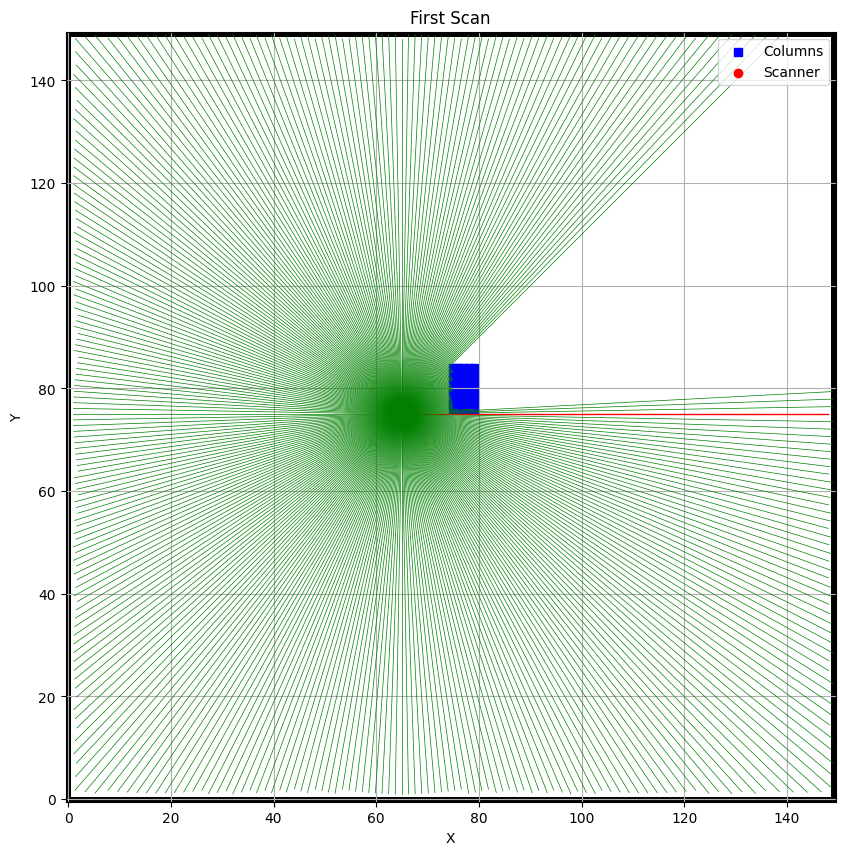

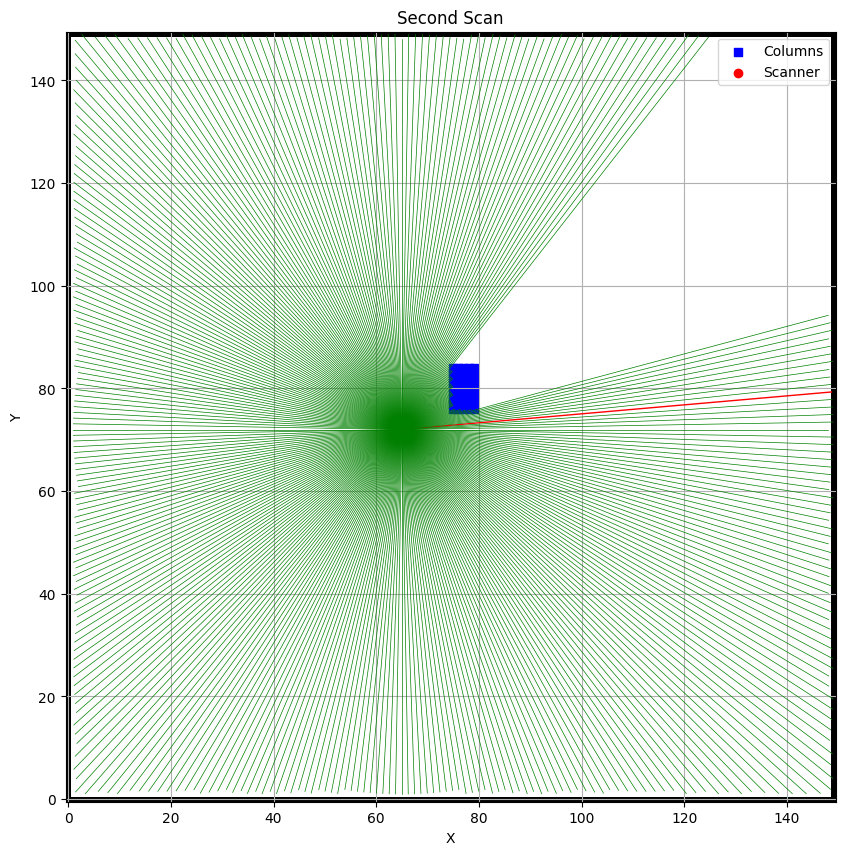

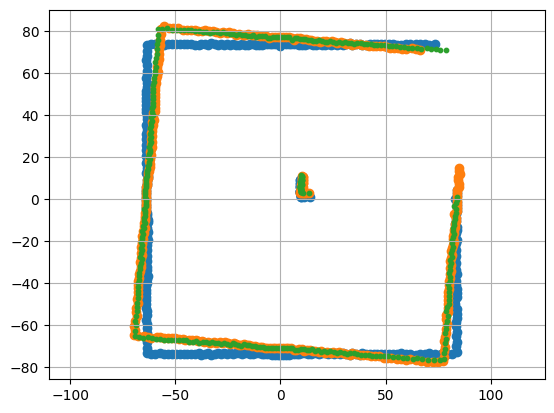

In [30]:
size = 150
room_size = (size, size)
room = np.zeros(room_size)

half_room_size = int(size / 2)

column_positions = [
    *[(half_room_size, half_room_size + i) for i in range(1, 10)],
    *[(half_room_size + 1, half_room_size + i) for i in range(1, 10)],
    *[(half_room_size + 2, half_room_size + i) for i in range(1, 10)],
    *[(half_room_size + 3, half_room_size + i) for i in range(1, 10)],
    *[(half_room_size + 4, half_room_size + i) for i in range(1, 10)],
]

for col in column_positions:
    room[col[::-1]] = 1

for i in range(size):
    room[(0, i)] = 1
    room[(i, 0)] = 1
    room[(i, size - 1)] = 1
    room[(size - 1, i)] = 1

first_position = (65, 75)
first_angle_start = 0

second_position = (65, 72)
second_angle_start = 5

do_scan_matching(first_position=first_position,
                 first_angle_start=first_angle_start,
                 second_position=second_position,
                 second_angle_start=second_angle_start,
                 room_size=size,
                 room=room,
                 column_positions=column_positions,
                 angle_step=1,
                 laser_scan_max_distance=200)